In [1]:
import os
import sqlite3
import pprint
from datetime import datetime

date_format = "%Y-%m-%d %H:%M:%S.%f"
failure_list = ["dependency", "divide_zero", "environment", "memory", "simple", "ulimit"]

def get_failure_type(workflow_cnt, repeat=3):
    i = workflow_cnt//repeat
    if i >= len(failure_list):
        return "unknown"
    else:
        return failure_list[i]

def process_workflow(runs_directory):
    workflow_list = []
    
    for root, dirs, files in os.walk(runs_directory):
        if 'monitoring.db' in files:
            info = {}
            db_path = os.path.join(root, 'monitoring.db')
            try:
                conn = sqlite3.connect(db_path)
                cursor = conn.cursor()

                # get run_id
                cursor.execute("SELECT run_id FROM workflow")
                rows = cursor.fetchall()
                info['run_id'] = rows[0][0]

                # get failure type
                info['failure_type'] = get_failure_type(len(workflow_list))

                # get success or not
                cursor.execute("SELECT task_fail_history FROM try WHERE task_id IS 5")
                rows = cursor.fetchall()
                info['success'] = False
                if len(rows) > 0:
                    for row in rows:
                        if row[0] == "":
                            info['success'] = True
                            break

                # get total time
                cursor.execute("SELECT task_try_time_returned, task_try_time_launched FROM try")
                rows = cursor.fetchall()
                
                total_time = 0
                for row in rows:
                    task_time_return = row[0]
                    task_time_launch = row[1]
                    if task_time_return is not None and task_time_launch is not None:
                        return_object = datetime.strptime(task_time_return, date_format)
                        return_timestamp = return_object.timestamp()
                        invoke_object = datetime.strptime(task_time_launch, date_format)
                        invoke_timestamp = invoke_object.timestamp()
                        total_time += return_timestamp - invoke_timestamp
                
                info['total_time'] = total_time
                
                conn.close()
            except sqlite3.Error as e:
                print(f"Error reading {db_path}: {e}")
            finally:
                workflow_list.append(info)
    
    return workflow_list



In [2]:
import pandas as pd
runs_directory = 'runs'  
plain_list = process_workflow(runs_directory)
plain_df = pd.DataFrame(plain_list)
plain_df

,run_id,failure_type,success,total_time
0,041661c3-e662-4d84-940b-e65ce2912e67,dependency,True,86.651104
1,f2fdce0d-a025-4117-8246-6272250d9f24,dependency,True,101.864298
2,70a7bb4d-099d-419f-a4c6-455fb3640b86,dependency,True,60.656652
3,88132f9e-35ba-47f8-a317-0435db1dcf01,divide_zero,True,196.533815
4,5fdff3e6-6488-42e9-96e6-93584189f3bc,divide_zero,True,109.559534
5,bbcbe9c1-92ff-462a-a34a-d859b31f8bf1,divide_zero,True,201.258747
6,0513c9ed-be03-42e4-b53c-435628a36e6c,environment,True,100.009761
7,876f23a8-29e3-4f14-a443-277e195f2b2a,environment,True,197.212339
8,e97c17c8-7d91-452b-bd8d-9956a36281a3,environment,True,168.723512
9,676c1ef7-0b63-4a0f-8ff6-a26561bf7536,memory,True,101.840233


In [3]:
retry_list = process_workflow('with')
retry_df = pd.DataFrame(retry_list)
retry_df

,run_id,failure_type,success,total_time
0,0f94b611-3ffc-4287-bd86-c300cecb30fb,dependency,False,136.543671
1,5c977f02-7a68-4e28-b5f4-2033ebb50a09,dependency,False,121.116459
2,7b9571d7-fdd5-422b-bbf8-c112196e88e0,dependency,False,62.455590
3,150a384b-073e-4629-a2c4-129a213e6e33,divide_zero,False,148.232162
4,31f0e879-61c9-49a7-a7c6-2a4bb0d5c6f7,divide_zero,False,149.638804
5,2eaf8101-cda6-4701-8ddd-e21d32196de9,divide_zero,True,125.387886
6,28624fe9-e07f-44f9-9f59-1857d4fcb972,environment,True,229.443027
7,5717057c-6950-4d20-b23b-54fbbc69fe61,environment,True,133.044207
8,3d17ef6f-b303-4c16-926a-9648843d120f,environment,True,593.606398
9,9fbace9d-2871-457a-a839-56762f6938ce,memory,False,116.033144


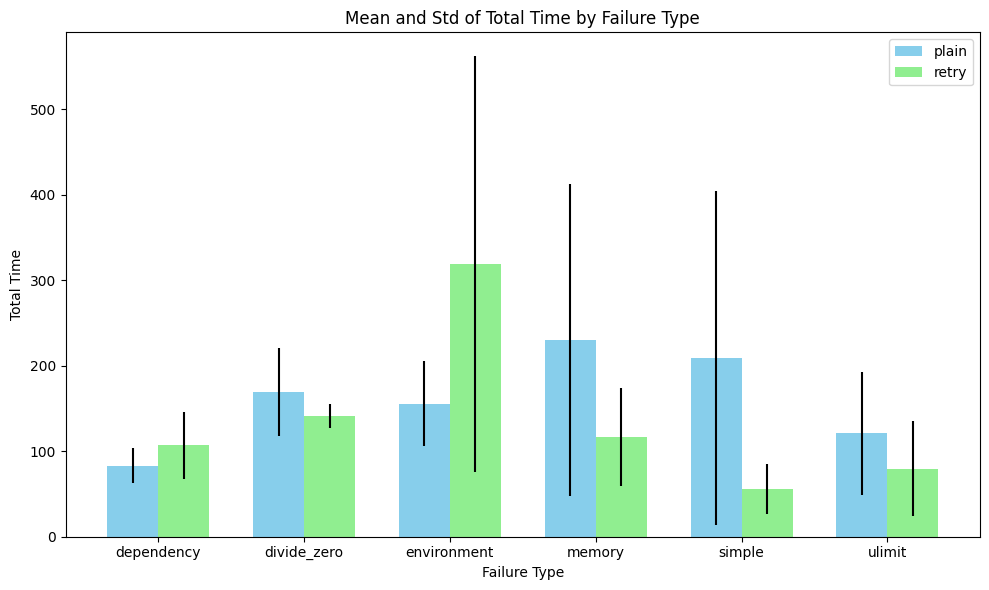

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 计算均值和方差
stats_df1 = plain_df.groupby('failure_type')['total_time'].agg(['mean', 'std']).reset_index()
stats_df2 = retry_df.groupby('failure_type')['total_time'].agg(['mean', 'std']).reset_index()

# 合并两个DataFrame
merged_stats = pd.merge(stats_df1, stats_df2, on='failure_type', suffixes=('_df1', '_df2'))

# 设置柱状图位置
x = np.arange(len(merged_stats['failure_type']))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# 绘制df1的柱状图
rects1 = ax.bar(x - width/2, merged_stats['mean_df1'], width, yerr=merged_stats['std_df1'], label='plain', color='skyblue')

# 绘制df2的柱状图
rects2 = ax.bar(x + width/2, merged_stats['mean_df2'], width, yerr=merged_stats['std_df2'], label='retry', color='lightgreen')

# 添加一些文本用于标签、标题和自定义x轴刻度
ax.set_xlabel('Failure Type')
ax.set_ylabel('Total Time')
ax.set_title('Mean and Std of Total Time by Failure Type')
ax.set_xticks(x)
ax.set_xticklabels(merged_stats['failure_type'])
ax.legend()

# 自动调整标签
fig.tight_layout()

# 显示图形
plt.show()
